In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
import anndata

from scroutines import basicu
from scroutines.config_plots import *
import importlib
importlib.reload(basicu)

<module 'scroutines.basicu' from '/scr/qlyu/projects/v1/scroutines/scroutines/basicu.py'>

In [2]:
sns.set_context('talk')

In [3]:
def get_pbulks(ddir, files, ncond, nrep, nclst, ngene):
    """
    """
    pbulks = []
    xclsts = []
    xcnsts = []
    for f in files:
        print(f)

        path = os.path.join(ddir, f)
        adata = anndata.read(path)
        genes = adata.var.index.values

        # adata = adata[adata.obs['Subclass'] == 'L2/3']
        mat = adata.X
        types = adata.obs['Type'].astype(str).values 
        # 1 or 2
        sample_codes = adata.obs['sample'].apply(lambda x: x.split('_')[-1][:-1].replace('3', '2')).astype(str).values
        sample_and_type = sample_codes + "_" + types
        unqs, cnts = np.unique(sample_and_type, return_counts=True)
        _xclsts, Xk, Xk_n, Xk_ln = basicu.counts_to_bulk_profiles(mat, sample_and_type) 

        # check all types + reps are the same
        if len(xclsts) > 0:
            if not np.all(_xclsts == xclsts):
                raise ValueError(_xclsts.shape, xclsts.shape, _xclsts, xclsts,)
            if not np.all(_xclsts == unqs):
                raise ValueError(_xclsts.shape, unqs.shape, _xclsts, unqs,)
        else:
            xclsts = _xclsts
            print(xclsts)

        pbulks.append(Xk_ln)
        xcnsts.append(cnts)

    pbulks = np.array(pbulks)
    xcnsts = np.array(xcnsts)
    
    pbulks = pbulks.reshape(ncond,nrep,nclst,-1)
    xclsts = xclsts.reshape(      nrep,nclst)
    xcnsts = xcnsts.reshape(ncond,nrep,nclst)
    
    return pbulks, xcnsts, xclsts, genes

# get data

In [4]:
ddir = '../data/cheng21_cell_scrna/organized/'

In [5]:
files = [
    # 'P8NR.h5ad',
    
    # 'P14NR.h5ad',
    
    # 'P17NR.h5ad',
    # 'P21NR.h5ad',
    'P28NR.h5ad',
    # 'P38NR.h5ad',
    
    # 'P28DR.h5ad',
    # 'P38DR.h5ad',
    
    # 'P28DL.h5ad',
] 
# conds = np.array([f.replace('.h5ad', '') for f in files])

ncond, nrep, nclst, ngene = len(files), 2, 42, -1
pbulks_nr, xcnsts, xclsts, genes = get_pbulks(ddir, files, ncond, nrep, nclst, ngene)

xclsts_short = np.array([clst[len("1_"):] for clst in xclsts[0]]) #, '_'
numcells = pd.DataFrame(xcnsts.T.reshape(-1,nrep*ncond), index=xclsts_short)
numcells

P28NR.h5ad
['1_Astro_A' '1_Astro_B' '1_Endo' '1_Frem1' '1_L2/3_A' '1_L2/3_B'
 '1_L2/3_C' '1_L4_A' '1_L4_B' '1_L4_C' '1_L5IT' '1_L5NP' '1_L5PT_A'
 '1_L5PT_B' '1_L6CT_A' '1_L6CT_B' '1_L6CT_C' '1_L6IT_A' '1_L6IT_B' '1_L6b'
 '1_Lamp5' '1_Micro' '1_OD_A' '1_OD_B' '1_OD_C' '1_OPC_A' '1_OPC_B'
 '1_Pvalb_A' '1_Pvalb_B' '1_Pvalb_C' '1_Pvalb_D' '1_Sst_A' '1_Sst_B'
 '1_Sst_C' '1_Sst_D' '1_Sst_E' '1_Stac' '1_VLMC_A' '1_VLMC_B' '1_Vip_A'
 '1_Vip_B' '1_Vip_C' '2_Astro_A' '2_Astro_B' '2_Endo' '2_Frem1' '2_L2/3_A'
 '2_L2/3_B' '2_L2/3_C' '2_L4_A' '2_L4_B' '2_L4_C' '2_L5IT' '2_L5NP'
 '2_L5PT_A' '2_L5PT_B' '2_L6CT_A' '2_L6CT_B' '2_L6CT_C' '2_L6IT_A'
 '2_L6IT_B' '2_L6b' '2_Lamp5' '2_Micro' '2_OD_A' '2_OD_B' '2_OD_C'
 '2_OPC_A' '2_OPC_B' '2_Pvalb_A' '2_Pvalb_B' '2_Pvalb_C' '2_Pvalb_D'
 '2_Sst_A' '2_Sst_B' '2_Sst_C' '2_Sst_D' '2_Sst_E' '2_Stac' '2_VLMC_A'
 '2_VLMC_B' '2_Vip_A' '2_Vip_B' '2_Vip_C']


,0,1
Astro_A,754,979
Astro_B,167,268
Endo,138,287
Frem1,39,60
L2/3_A,296,316
L2/3_B,1218,1164
L2/3_C,557,493
L4_A,993,952
L4_B,1028,1001
L4_C,408,350


In [6]:
pbulks_nr.shape 

(1, 2, 42, 53801)

# check total counts

In [7]:
f = "../results/MERFISH_gene_panel_Working_Mar9.csv"
df = pd.read_csv(f)
# df = df[df['why included'].str.contains('All cell types') & 
#         df['source'].str.contains('analysis')
#        ]
# df = df[df['why included'].str.contains('Microglia')
#         # & df['source'].str.contains('analysis')
#        ]
cnddts = df['gene_name_data'].values
unq, cnts = np.unique(cnddts, return_counts=True)
print(len(cnddts), unq.shape, unq[cnts>1], [g for g in cnddts if g not in genes])

gidx = basicu.get_index_from_array(genes, cnddts)
assert np.all(gidx!=-1)

506 (506,) [] []


In [8]:
dfsub = df[df['why included'].str.contains('L2/3 types')  
           # & df['source'].str.contains('analysis')
          ]
print(dfsub.shape)
gidx2 = basicu.get_index_from_array(genes, dfsub['gene_name_data'])

assert np.all(gidx2!=-1)

(170, 16)


In [9]:
exp0 = np.mean(pbulks_nr[:,:,:,:], axis=(0,1)).T # [0,0,:,:].T #.shape
exp1 = np.mean(pbulks_nr[:,:,:,gidx], axis=(0,1)).T # [0,0,:,:].T #.shape
exp2 = np.mean(pbulks_nr[:,:,:,gidx2], axis=(0,1)).T # [0,0,:,:].T #.shape

cov0 = np.sum(np.power(10, exp0)-1, axis=0)
cov1 = np.sum(np.power(10, exp1)-1, axis=0)
cov2 = np.sum(np.power(10, exp2)-1, axis=0)

In [10]:
def plot_cov(cov, lbl=None, ax=None):
    """
    """
    ax.bar(np.arange(len(cov)), cov, label=lbl)
    ax.set_xticks(np.arange(len(cov)))
    ax.set_xticklabels(xclsts_short, rotation=90)
    return ax

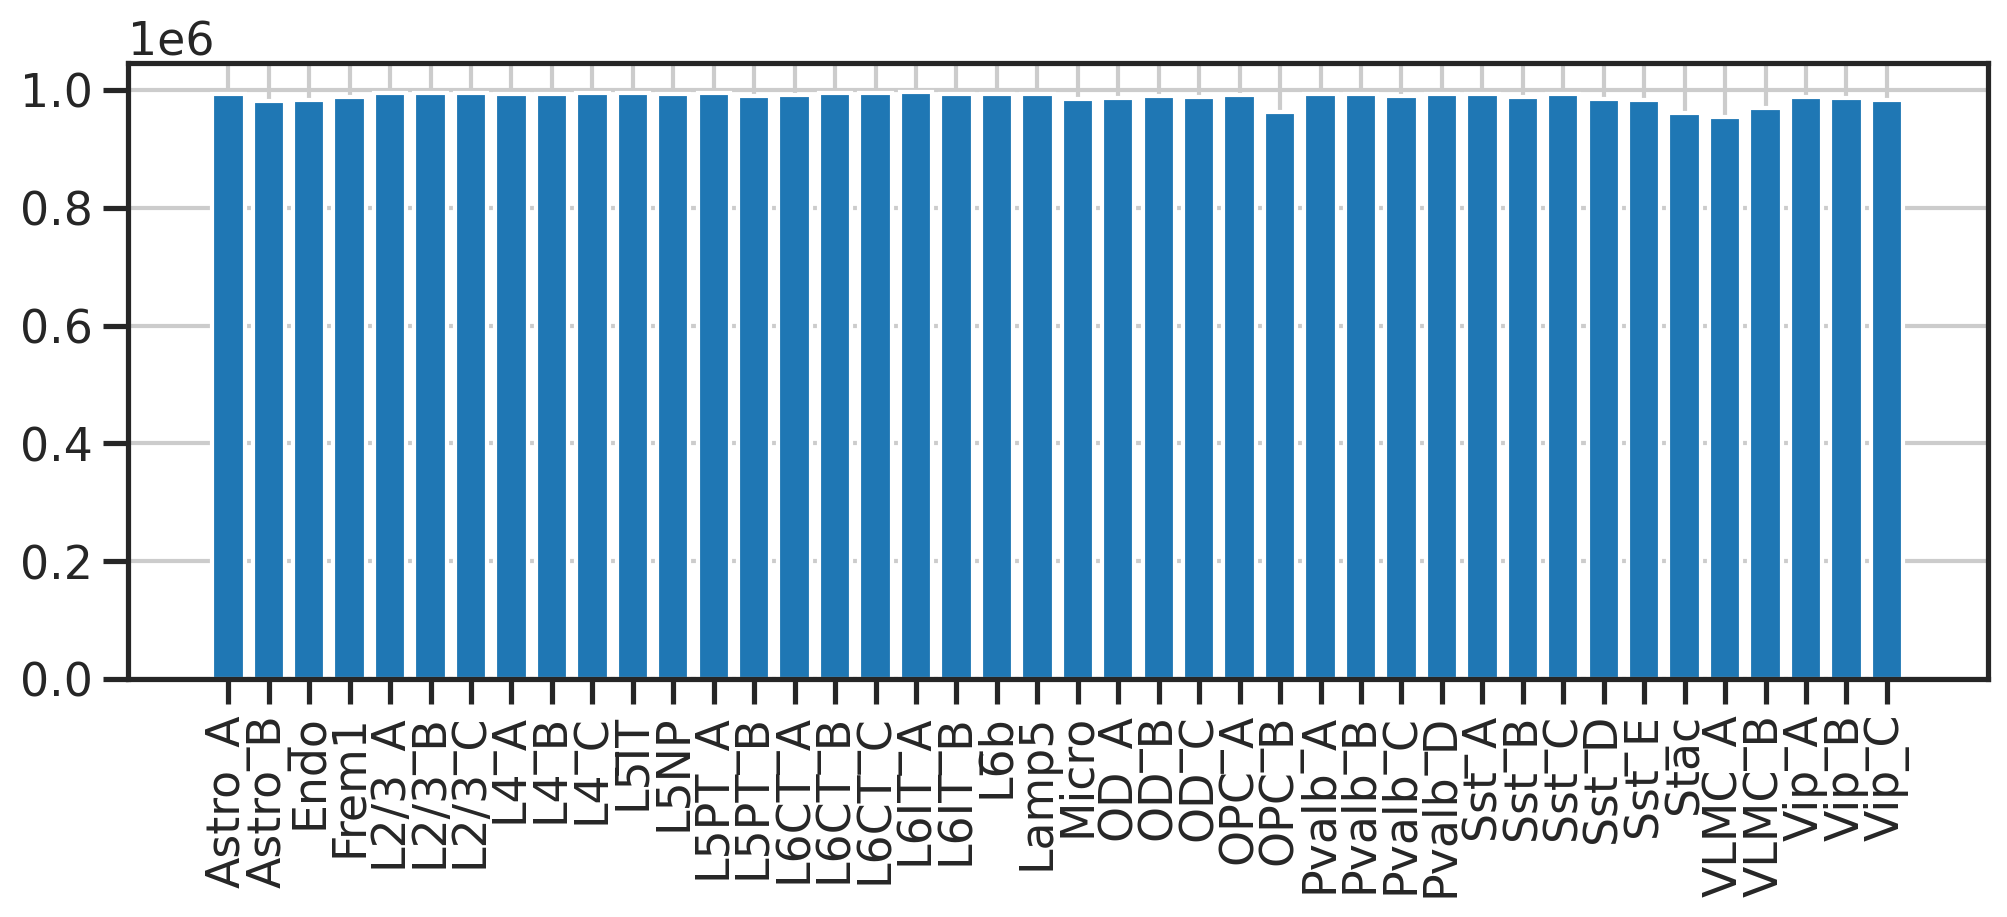

In [11]:
fig, ax = plt.subplots(figsize=(12,4))
plot_cov(cov0, ax=ax)
plt.show()

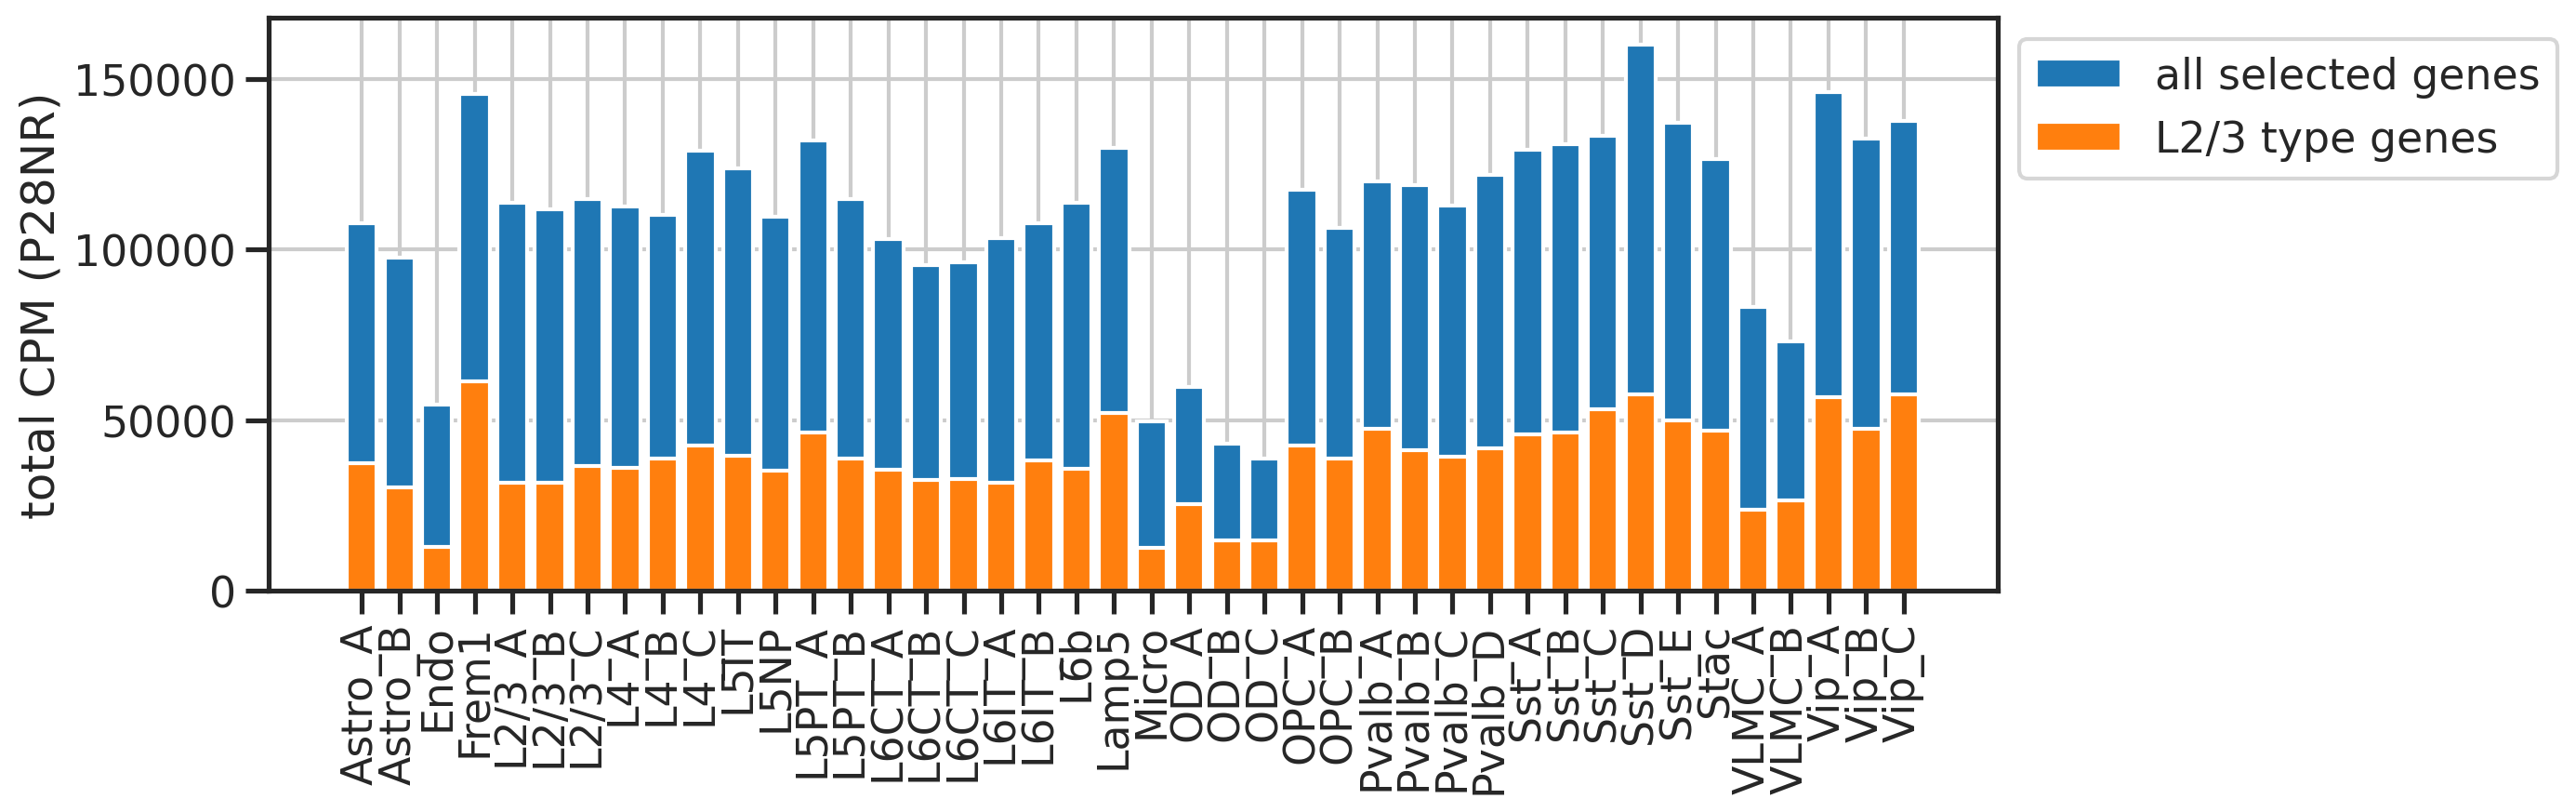

In [12]:
fig, ax = plt.subplots(figsize=(12,4))
plot_cov(cov1, ax=ax, lbl='all selected genes')
plot_cov(cov2, ax=ax, lbl='L2/3 type genes')
ax.set_ylabel('total CPM (P28NR)')
ax.legend(bbox_to_anchor=(1,1))
plt.show()

# check most abundant genes in L2/3

In [13]:
cidx = basicu.get_index_from_array(xclsts_short, ['L2/3_A', 'L2/3_B', 'L2/3_C'])

array([4, 5, 6])

In [14]:
tocheck = np.mean(pbulks_nr[:,:,cidx,:][:,:,:,gidx], axis=(0,1)).T
tocheck.shape

In [16]:
gidxsub_a = np.argsort(tocheck[:,0])[::-1]
gidxsub_b = np.argsort(tocheck[:,1])[::-1]
gidxsub_c = np.argsort(tocheck[:,2])[::-1]

In [25]:
gidxsub_all = np.union1d(gidxsub_a[:10], gidxsub_b[:10])
gidxsub_all = np.union1d(gidxsub_all, gidxsub_c[:10])
gidxsub_all.shape

(15,)

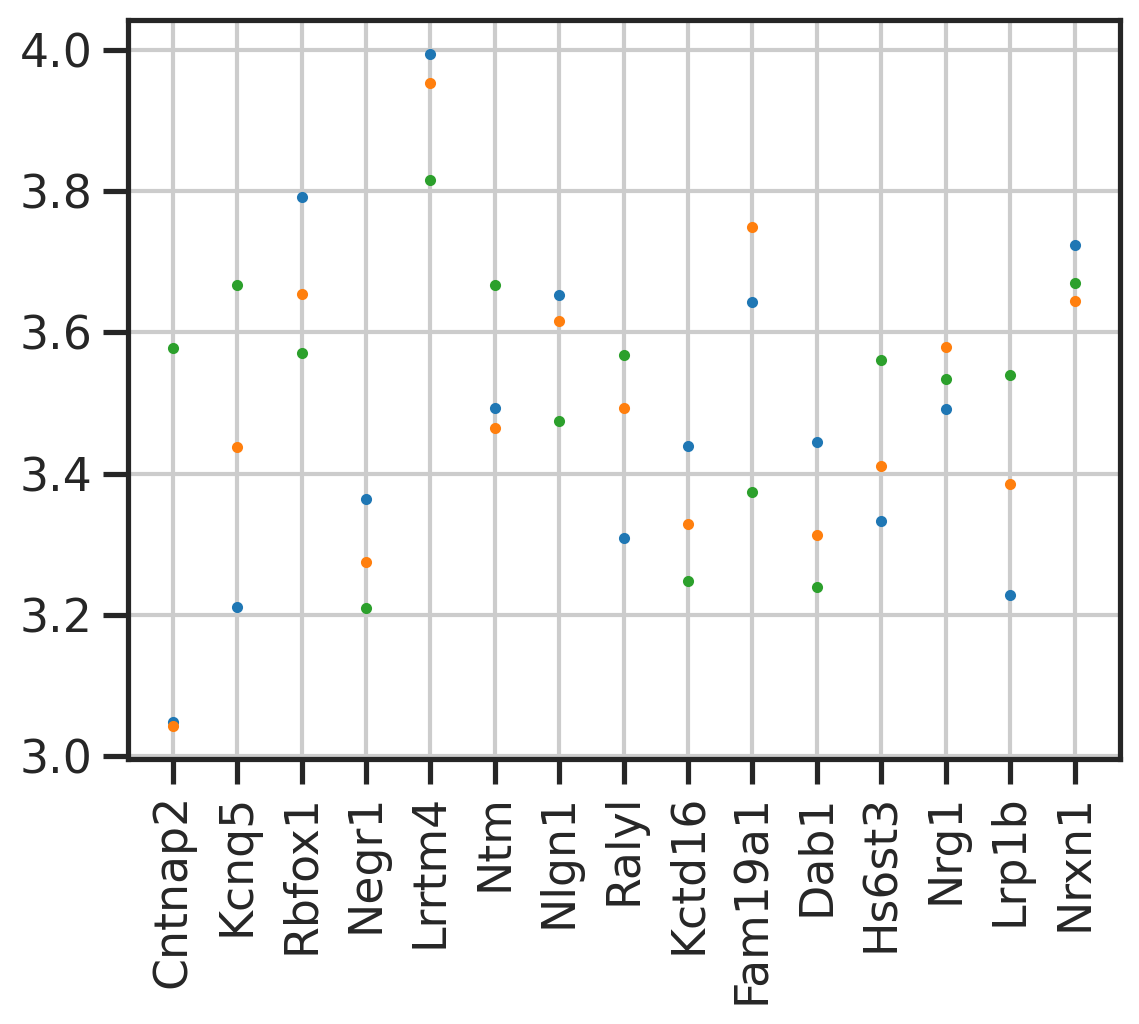

In [28]:
fig, ax = plt.subplots()
ax.plot(tocheck[gidxsub_all, 0], 'o', markersize=3)
ax.plot(tocheck[gidxsub_all, 1], 'o', markersize=3)
ax.plot(tocheck[gidxsub_all, 2], 'o', markersize=3)
ax.set_xticks(np.arange(len(gidxsub_all)))
ax.set_xticklabels(cnddts[gidxsub_all], rotation=90)
plt.show()

In [30]:
cnddts[gidxsub_all]

array(['Cntnap2', 'Kcnq5', 'Rbfox1', 'Negr1', 'Lrrtm4', 'Ntm', 'Nlgn1',
       'Ralyl', 'Kctd16', 'Fam19a1', 'Dab1', 'Hs6st3', 'Nrg1', 'Lrp1b',
       'Nrxn1'], dtype=object)

# Check all panels